<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#NEEDS-TO-BE-UPDATED-IN-ACCORDANCE-WITH-ETF-Market-Internals_Test-Class-Script.ipynb" data-toc-modified-id="NEEDS-TO-BE-UPDATED-IN-ACCORDANCE-WITH-ETF-Market-Internals_Test-Class-Script.ipynb-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>NEEDS TO BE UPDATED IN ACCORDANCE WITH <code>ETF Market Internals_Test Class Script.ipynb</code></a></span></li></ul></div>

## NEEDS TO BE UPDATED IN ACCORDANCE WITH `ETF Market Internals_Test Class Script.ipynb`

In [1]:
"""
Script to examine performance of Long/Short Portfolio

Factor: Cross-Sectional Return Bins

Strategy Classification: Long/Short Market-Neutral Momentum 

1) Calculate return bins for each ETF Symbol's components (weekly)
2) Compare return bins across ETFs
3) Long N top ETFs that exceed PERCENTAGE threshold; Short N worst ETFs that exceed PERCENTAGE threshold.
4) Equal Weight, Risk-Parity, Minimum Correlation Algorithm
5) Hold N weeks and repeat
"""

"\nScript to examine performance of Long/Short Portfolio\n\nFactor: Cross-Sectional Return Bins\n\nStrategy Classification: Long/Short Market-Neutral Momentum \n\n1) Calculate return bins for each ETF Symbol's components (weekly)\n2) Compare return bins across ETFs\n3) Long N top ETFs that exceed PERCENTAGE threshold; Short N worst ETFs that exceed PERCENTAGE threshold.\n4) Equal Weight, Risk-Parity, Minimum Correlation Algorithm\n5) Hold N weeks and repeat\n"

In [2]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2
# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)
script_dir = pdir / 'src' 
viz_dir = pdir / 'report' / 'figures'
data_dir = pdir / 'data'
script_dirs = list(Path(script_dir).glob('./*/'))
for sdir in script_dirs: sys.path.append(sdir.as_posix())

import _blk_utilities_
import _blk_ETF_Internals_
utils = _blk_utilities_.utilities()

from decimal import Decimal
dplaces = Decimal('0.0001')

import pandas as pd
from pandas.tseries.offsets import *
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
sz = 11
mlt = 1.66
size=(mlt * sz, sz)
import seaborn as sns
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))
from collections import OrderedDict as od
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno

print()
%watermark -p pandas,pandas_datareader,dask,numpy,matplotlib,seaborn

Wall time: 1.1 s


In [3]:
def _quantize(val):
    return Decimal(val).quantize(dplaces)

def _format_bins(npos, nneg):
    npos['Percent of Total Stocks'] = npos['Percent of Total Stocks'].apply(_quantize)
    nneg['Percent of Total Stocks'] = nneg['Percent of Total Stocks'].apply(_quantize)
    return npos, nneg

"""Create combined dataframe"""
def _add_columns(df, empty_df, etf_sym):
    empty_df[etf_sym] = df['Percent of Total Stocks']
    return empty_df

In [4]:
"""
import sample holdings from ETF
"""
def _remove_cash_holdings(etf):
    return pd.Series([sym for sym in etf if 'CASH' not in sym])
# ============================================================================================ #
# EUROPE
def _format_FTSE_symbols():
    ftse100 = pd.read_csv(project_path + r'_ETF_Holdings\_Foreign\ISF_holdings.csv', skiprows=2)
    ftse100 = ftse100[ ftse100['Sector'] != r'Cash and/or Derivatives' ].dropna()
    ftse100 = (ftse100['Issuer Ticker'].replace(['/', '\.'], '', regex=True)).sort_values().reset_index(drop=True)    
    idx_loc = None
    for i in range(len(ftse100)):
        if ftse100.ix[i] == 'BTA':
            idx_loc = i
    ftse100[idx_loc] = 'BT-A'
    ftse100 =   pd.Series( [sec + '.L' for sec in ftse100 ] ).map(str.strip)
    return ftse100

def _format_DAX_symbols():
    dax = pd.read_csv(project_path + r'_ETF_Holdings\_Foreign\EXS1_holdings.csv', skiprows=2)
    dax = dax[ dax['Sector'] != r'Cash and/or Derivatives' ].dropna()    
    dax = pd.Series( [sec + '.DE' for sec in dax['Issuer Ticker'] ] ).map(str.strip)
    return dax
# ============================================================================================ #
# CANADA

def _format_TSX_symbols():
    tsx = pd.read_csv(project_path + r'_ETF_Holdings\_Foreign\XIU_holdings.csv', skiprows=10)
    tsx = tsx[ tsx['Sector'] != r'Cash and/or Derivatives' ].dropna()
    tsx = utils._clean_symbols_strings(tsx['Ticker'])
    tsx = pd.Series( [sec + '.TO' for sec in tsx] ).map(str.strip)
    return tsx
# ============================================================================================ #
# AUSTRALIA
def _format_ASX_symbols():
    asx = pd.read_excel(project_path + r'_ETF_Holdings\_Foreign\fund_allholdings_STW.xls', skiprows=4)
    asx = asx[asx['Sector Classification'] != 'Unassigned']  
    asx = asx['Ticker'].map(str.strip)
    asx = asx.replace('-AU', '.AX', regex=True)
    return asx
# ============================================================================================ #
# US MAJOR AVERAGES

def _format_SPY_symbols():
    spy = pd.read_excel(project_path + r'_ETF_Holdings\_SPDR_holdings\holdings-spy.xls', skiprows=3)
    spy = spy[spy['Shares Held']>0]
    spy = spy['Identifier'].map(str.strip)
    spy = utils._clean_symbols_strings(spy)
    spy = _remove_cash_holdings(spy)
    return spy

def _format_DIA_symbols():
    dia = pd.read_excel(project_path + r'_ETF_Holdings\_SPDR_holdings\holdings-dia.xls', skiprows=3)
    dia = dia[(dia['Shares Held']>0) & (dia['Identifier'] != 'CASH_USD')]    
    dia = dia['Identifier'].map(str.strip)
    return dia

def _format_QQQ_symbols():
    qqq = pd.read_csv(project_path + r'_ETF_Holdings\_QQQ_holdings\holdings-QQQ.csv')
    qqq = qqq['HoldingsTicker'].map(str.strip)
    qqq = _remove_cash_holdings(qqq)
    return qqq
# ============================================================================================ #
# SECTOR SPDRS

def _format_XLB_symbols():
    syms = pd.read_excel(project_path + r'_ETF_Holdings\_SPDR_holdings\holdings-xlb.xls', skiprows=1)
    syms = syms['Symbol'].map(str.strip)
    syms = utils._clean_symbols_strings(syms) 
    syms = _remove_cash_holdings(syms)
    return syms

def _format_XLE_symbols():
    syms = pd.read_excel(project_path + r'_ETF_Holdings\_SPDR_holdings\holdings-xle.xls', skiprows=1)
    syms = syms['Symbol'].map(str.strip)
    syms = utils._clean_symbols_strings(syms)
    syms = _remove_cash_holdings(syms)
    return syms

def _format_XLF_symbols():
    syms = pd.read_excel(project_path + r'_ETF_Holdings\_SPDR_holdings\holdings-xlf.xls', skiprows=1)
    syms = syms['Symbol'].map(str.strip)
    syms = utils._clean_symbols_strings(syms)
    syms = _remove_cash_holdings(syms)
    return syms

def _format_XLI_symbols():
    syms = pd.read_excel(project_path + r'_ETF_Holdings\_SPDR_holdings\holdings-xli.xls', skiprows=1)
    syms = syms['Symbol'].map(str.strip)
    syms = _remove_cash_holdings(syms)
    return syms

def _format_XLK_symbols():
    syms = pd.read_excel(project_path + r'_ETF_Holdings\_SPDR_holdings\holdings-xlk.xls', skiprows=1)
    syms = syms['Symbol'].map(str.strip)
    syms = utils._clean_symbols_strings(syms)
    syms = _remove_cash_holdings(syms)
    return syms

def _format_XLP_symbols():
    syms = pd.read_excel(project_path + r'_ETF_Holdings\_SPDR_holdings\holdings-xlp.xls', skiprows=1)
    syms = syms['Symbol'].map(str.strip)
    syms = utils._clean_symbols_strings(syms)
    syms = _remove_cash_holdings(syms)
    return syms

def _format_XLU_symbols():
    syms = pd.read_excel(project_path + r'_ETF_Holdings\_SPDR_holdings\holdings-xlu.xls', skiprows=1)
    syms = syms['Symbol'].map(str.strip)
    syms = utils._clean_symbols_strings(syms)
    syms = _remove_cash_holdings(syms)
    return syms

def _format_XLV_symbols():
    syms = pd.read_excel(project_path + r'_ETF_Holdings\_SPDR_holdings\holdings-xlv.xls', skiprows=1)
    syms = syms['Symbol'].map(str.strip)
    syms = utils._clean_symbols_strings(syms)
    syms = _remove_cash_holdings(syms)
    return syms

def _format_XLY_symbols():
    syms = pd.read_excel(project_path + r'_ETF_Holdings\_SPDR_holdings\holdings-xly.xls', skiprows=1)
    syms = syms['Symbol'].map(str.strip)
    syms = utils._clean_symbols_strings(syms)
    syms = _remove_cash_holdings(syms)
    return syms

# ============================================================================================ #
'''
def _format_STOXX_symbols():
    stoxx50 = pd.read_csv(project_path + r'_ETF_Holdings\_Foreign\EUE_holdings.csv', skiprows=2)
    stoxx50= stoxx50[ stoxx50['Sector'] != r'Cash and/or Derivatives' ].dropna()    
    stoxx50 = pd.Series( [sec + '.PA' for sec in stoxx50['Issuer Ticker'] ] ).map(str.strip)
    return stoxx50
    
'''    

# ============================================================================================ #
# EUROPE
FTSE = _format_FTSE_symbols()
DAX = _format_DAX_symbols()
# ============================================================================================ #
# CANADA
TSX = _format_TSX_symbols()
# ============================================================================================ #
# AUSTRALIA
ASX = _format_ASX_symbols()
# ============================================================================================ #
# US MAJOR AVERAGES

SPY = _format_SPY_symbols()
DIA = _format_DIA_symbols()
QQQ = _format_QQQ_symbols()
# ============================================================================================ #
# SECTOR SPDRS

XLB = _format_XLB_symbols()
XLE = _format_XLE_symbols()
XLF = _format_XLF_symbols()
XLI = _format_XLI_symbols()
XLK = _format_XLK_symbols()
XLP = _format_XLP_symbols()
XLU = _format_XLU_symbols()
XLV = _format_XLV_symbols()
XLY = _format_XLY_symbols()

all_etf_symbols = od([
                    ('SPY',SPY), ('DIA',DIA), ('QQQ',QQQ), 
                    ('XLB',XLB), ('XLE',XLE), ('XLF',XLF), 
                    ('XLI',XLI), ('XLK',XLK), ('XLP',XLP), 
                    ('XLU',XLU), ('XLV',XLV), ('XLY',XLY),
                    ('FTSE',FTSE), ('DAX',DAX), ('TSX',TSX), ('ASX',ASX)        
                    ])


In [5]:
import importlib 
importlib.reload(_blk_ETF_Internals_)
etfi = _blk_ETF_Internals_.etfInternals()

# get query dates anchored to last 52 weeks Monday
start_query, end_query = etfi._get_query_dates()
date_format = utils._create_date_format(start_query, end_query)
print(start_query, end_query, date_format)

'creating directory...'
'directory created [complete]'
2014-03-31 00:00:00 2016-03-25 00:00:00 [Monday, 03.31.2014 - Friday, 03.25.2016]


In [6]:
%%time
# Get ETF Indices price data for performance analytics
etf_syms = ['SPY', 'DIA', 'QQQ', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', \
            'XLP', 'XLU', 'XLV', 'XLY', '^FTSE', '^GDAXI', '^GSPTSE', '^AXJO']

def _get_px(symbol, start, end):
    return web.DataReader(symbol, 'yahoo', start, end)['Adj Close']

ETF_px = pd.DataFrame()
for sym in etf_syms:
    ETF_px[sym] = _get_px(sym, start_query, end_query)

rets = np.log(ETF_px / ETF_px.shift(1)).dropna()
print(rets.describe())

              SPY         DIA         QQQ         XLB         XLE         XLF  \
count  447.000000  447.000000  447.000000  447.000000  447.000000  447.000000   
mean     0.000413    0.000366    0.000671    0.000165   -0.000424    0.000198   
std      0.009223    0.009032    0.010998    0.011641    0.015942    0.010795   
min     -0.043019   -0.037366   -0.044690   -0.042811   -0.066400   -0.043664   
25%     -0.004124   -0.004256   -0.004531   -0.006514   -0.008980   -0.005332   
50%      0.000585    0.000743    0.000768    0.000822   -0.000258    0.000834   
75%      0.005132    0.005392    0.006418    0.006836    0.008051    0.006334   
max      0.037675    0.038670    0.049135    0.035693    0.048277    0.041351   

              XLI         XLK         XLP         XLU         XLV         XLY  \
count  447.000000  447.000000  447.000000  447.000000  447.000000  447.000000   
mean     0.000380    0.000666    0.000641    0.000723    0.000431    0.000564   
std      0.009993    0.0105

In [7]:
%%time
"""
Get all ETF Internals via Loop
"""
# ======================================================================= #
def _single_run_download(ETF_symbol, symbols, *args):
    """Get Symbol data"""
    location_h5 = etfi._get_symbol_px_data(ETF_symbol, symbols)
# ======================================================================= #   
def _calc_return_thresholds(list_of_thresholds, log_returns, N_stocks, pos=None):
        """Function to calculate the quantity of stocks meeting or exceeding a return threshold

        Parameters:
        ===========
        list_of_thresholds: a list of each return level
        log_returns: dataframe of equity returns
        pos = boolean, if True calculates positive thresholds else negative

        Returns:
        ========
        N_thresh = pd.Series() with stock counts for each return threshold
        """
        if pos:
            N_thresh = pd.DataFrame(columns=['Count', 'Percent of Total Stocks'], index=list_of_thresholds)
            for thresh in list_of_thresholds:
                l = [1 for i in log_returns.ix[-1] if i > thresh]
                N_thresh.loc[thresh]['Count'] = sum(l)
            N_thresh['Percent of Total Stocks'] = (N_thresh['Count'] / N_stocks)
            return N_thresh
        else:
            N_thresh = pd.DataFrame(columns=['Count', 'Percent of Total Stocks'], index=list_of_thresholds)
            for thresh in list_of_thresholds:
                l = [1 for i in log_returns.ix[-1] if i <= thresh]
                N_thresh.loc[thresh]['Count'] = sum(l)
            N_thresh['Percent of Total Stocks'] = (N_thresh['Count'] / N_stocks)
            return N_thresh  
        
# ======================================================================= #    
def _get_return_bins(ETF_symbol, symbols, location_h5, start_date, end_date): 
    """Extract Close Prices"""
    px = etfi._extract_adjclose_px(location_h5, symbols)

    """Set key parameters"""
    N_stocks = len(px.columns)
    log_returns = etfi._calc_log_returns(px)
    log_returns = log_returns.ix[start_date:end_date]

    """Calculate thresholds"""
    pos_thresh = [0., .01, .02, .03, .04, .05, .06, .07, .1, .15, .2]
    neg_thresh = [ flt * -1. for flt in pos_thresh ]

    N_pos = _calc_return_thresholds(pos_thresh, log_returns.resample('1W', how='sum'), N_stocks, pos=True)
    N_neg = _calc_return_thresholds(neg_thresh, log_returns.resample('1W', how='sum'), N_stocks)
    return N_pos, N_neg
# ======================================================================= #
def _weekly_returns(ETF_symbol, returns, start_date, end_date): 
    """Set Key parameters"""
    selected_returns = returns.ix[start_date:end_date]
    by_week_returns = selected_returns.sum()
    return by_week_returns
# ======================================================================= #
def _convert_symbol(symbol, reverse=None):
    '''function to convert foreign indices symbol to yahoo finance symbol'''
    if not reverse:
        incompatible_syms = ['FTSE','DAX','TSX','ASX']
        compatible_syms = ['^FTSE', '^GDAXI', '^GSPTSE', '^AXJO']

        compatible_symbol = None # Declare symbol
        # iterate to check if any symbols are incompatible
        for inc in incompatible_syms:
            if symbol == inc:
                idx_loc = incompatible_syms.index(inc)
                compatible_symbol = compatible_syms[idx_loc]
                return compatible_symbol
        # if compatible_symbol is None then symbol is good; return it
        if not compatible_symbol:
            return symbol
    elif reverse:
        compatible_syms = ['FTSE','DAX','TSX','ASX']
        incompatible_syms = ['^FTSE', '^GDAXI', '^GSPTSE', '^AXJO']

        compatible_symbol = None # Declare symbol
        # iterate to check if any symbols are incompatible
        for inc in incompatible_syms:
            if symbol == inc:
                idx_loc = incompatible_syms.index(inc)
                compatible_symbol = compatible_syms[idx_loc]
                return compatible_symbol

        # if compatible_symbol is None then symbol is good; return it
        if not compatible_symbol:
            return symbol        
# ======================================================================= #        

Wall time: 0 ns


In [8]:
today = pd.datetime.today().date()
date_str = today.strftime('%m-%d-%y')

start = today - 252 * BDay()
idx_monday = pd.bdate_range(start, today - 5 * BDay(), freq='W-MON')
idx_friday = pd.bdate_range(start, today, freq='W-FRI')
print(idx_friday[:5])
print(idx_monday[:5])

dates = []
n = 0
for ifri in idx_friday[1:]:
    try:
        n += 1
        imon = idx_monday[n - 1]
        dates.append((ifri, imon))
    except: break

DatetimeIndex(['2015-04-10', '2015-04-17', '2015-04-24', '2015-05-01',
               '2015-05-08'],
              dtype='datetime64[ns]', freq='W-FRI')
DatetimeIndex(['2015-04-13', '2015-04-20', '2015-04-27', '2015-05-04',
               '2015-05-11'],
              dtype='datetime64[ns]', freq='W-MON')


In [10]:
%%time
# ~ 7-8 minutes to run
idx = range(len(dates))
by_date_pos = od()
by_date_neg = od()

for i in idx:
    pos_df = pd.DataFrame()
    neg_df = pd.DataFrame()
    for etf_sym, symbols in all_etf_symbols.items():
        today = pd.datetime.today().date()
        date_str = today.strftime('%m-%d-%y')
        location = price_path + r'{}\{} ETF Market Internals Price Data {}.h5'.format(date_str, etf_sym, date_str)

        MON, FRI = 1, 0
        start_date = dates[i][MON]
        end_date = dates[i][FRI]

        npos, nneg = _get_return_bins(etf_sym, symbols, location, start_date, end_date)
        npos, nneg = _format_bins(npos, nneg)    

        pos_df = _add_columns(npos, pos_df, etf_sym)
        neg_df = _add_columns(nneg, neg_df, etf_sym)
        
    by_date_pos[start_date] = pos_df
    by_date_neg[start_date] = neg_df

Wall time: 7min 28s


In [11]:
%%time
IDX = range(len(dates))
MON, FRI = 1, 0
by_date_returns = od()

for n in IDX:
    for sym in all_etf_symbols.keys():
        today = pd.datetime.today().date()       
        start_date = dates[n][1] # [MON]
        end_date = dates[n][0] # [FRI]

        SYM = _convert_symbol(sym)
        tmp_rets = _weekly_returns(SYM, rets, start_date, end_date)
        
        idx = []
        for i in tmp_rets.index:
            sec = _convert_symbol(i, reverse=True)
            idx.append(sec)
        tmp_df = pd.DataFrame(index=idx)
        tmp_rets.index = idx
        tmp_df['weekly_returns'] = tmp_rets
        # print(tmp_df)
        
    by_date_returns[start_date] = tmp_rets

Wall time: 668 ms


In [22]:
"""
Get time series of returns for Symbols in the top quintile of return distribution

1. Select positive(negative) return bins
2. Group by Percent Total of return distro
3. Select group
4. Examine next week's returns
5. Store results
"""

# POSITIVE THRESHOLDS
mondays = [date[MON] for date in dates]
fridays = [date[FRI] for date in dates]
#len(list(pos_bin_dict.items())) # <= index due based on positive or negative thresholds exceeded
# ======================================================================= #
pos_thresh = [0., .01, .02, .03, .04, .05, .06, .07, .1, .15, .2]
neg_thresh = [ flt * -1. for flt in pos_thresh ]

pbt_dict = {} # agg pos_bin_dict by return thresholds
# calculate quintiles
for thresh in pos_thresh:
    try:
        pos_bin_dict = {}
        for k, v in by_date_pos.items():
            tmp = pd.DataFrame()
            tmp['Percent_Total'] = v.loc[thresh].astype(float)
            tmp['Quintiles'] = pd.qcut(tmp['Percent_Total'], 2, labels=False)
            pos_bin_dict[k] = tmp.sort_values('Percent_Total', ascending=False)
    except: pass
    pbt_dict[thresh] = pos_bin_dict

# ======================================================================= #
HPR = {} # hpr by thresh
for thresh in pbt_dict.keys():
    hpr_long = pd.Series() # long portfolio holding period rets
    hpr_short = pd.Series()
    LS = pd.Series()
    for k, v in pbt_dict[thresh].items():
        tgt_date = pd.to_datetime(k)
        # select quintile and get symbols
        top_q_syms = list(v[v['Quintiles']==0].index)
        bottom_q_syms = list(v[v['Quintiles']==1].index)
        try:
            for i, n in enumerate(dates):
                if n[MON] == tgt_date: # get location of date
                    next_monday_close = dates[i + 1][MON]
        except: continue
        
        hpr_long.loc[tgt_date.date().strftime('%m-%d-%y')] = by_date_returns[next_monday_close][top_q_syms].mean()
        hpr_short.loc[tgt_date.date().strftime('%m-%d-%y')] = by_date_returns[next_monday_close][bottom_q_syms].mean()
        
        long = hpr_long.loc[tgt_date.date().strftime('%m-%d-%y')]
        short = hpr_short.loc[tgt_date.date().strftime('%m-%d-%y')]
        
        LS.loc[tgt_date.date().strftime('%m-%d-%y')] = long - short
    HPR[thresh] = LS

# ======================================================================= #
for thresh in sorted(list(pbt_dict.keys())):
    try:
        print('positive threshold: {:3.2%} | mean return: {:3.2%} | sum: {:3.2%}'.format(thresh,
                                                                          Decimal(HPR[thresh].mean()).quantize(dplaces),
                                                                          Decimal(HPR[thresh].sum()).quantize(dplaces)
                                                                                        ))
    except: pass

positive threshold: 0.00% | mean return: 0.15% | sum: 7.57%
positive threshold: 1.00% | mean return: 0.39% | sum: 7.10%
positive threshold: 2.00% | mean return: 0.40% | sum: 7.23%
positive threshold: 3.00% | mean return: 0.34% | sum: 6.14%
positive threshold: 4.00% | mean return: 0.25% | sum: 4.55%
positive threshold: 5.00% | mean return: 0.23% | sum: 1.39%
positive threshold: 6.00% | mean return: 0.14% | sum: 0.82%
positive threshold: 7.00% | mean return: 0.55% | sum: 2.19%
positive threshold: 10.00% | mean return: NaN% | sum: 0.00%
positive threshold: 15.00% | mean return: NaN% | sum: 0.00%
positive threshold: 20.00% | mean return: NaN% | sum: 0.00%


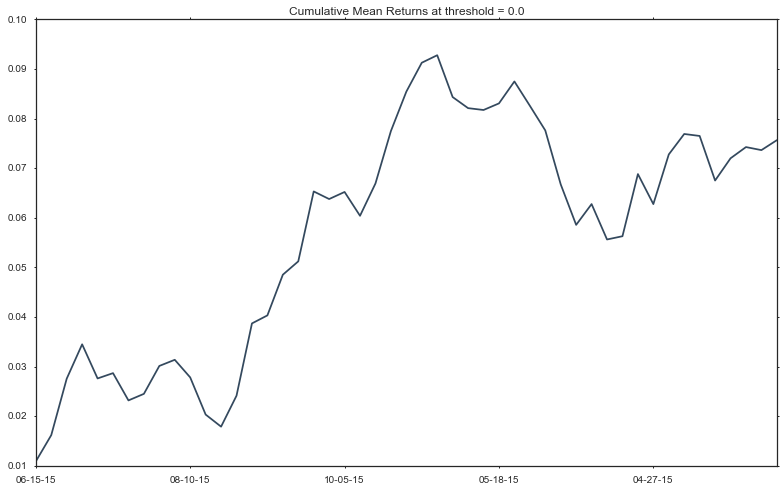

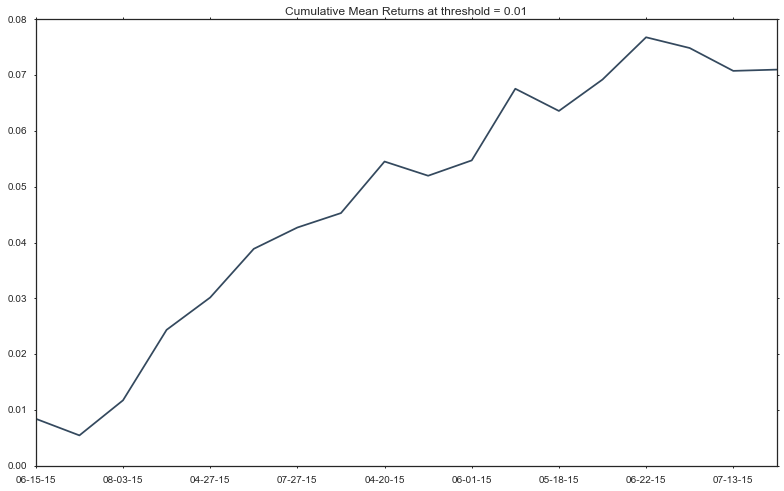

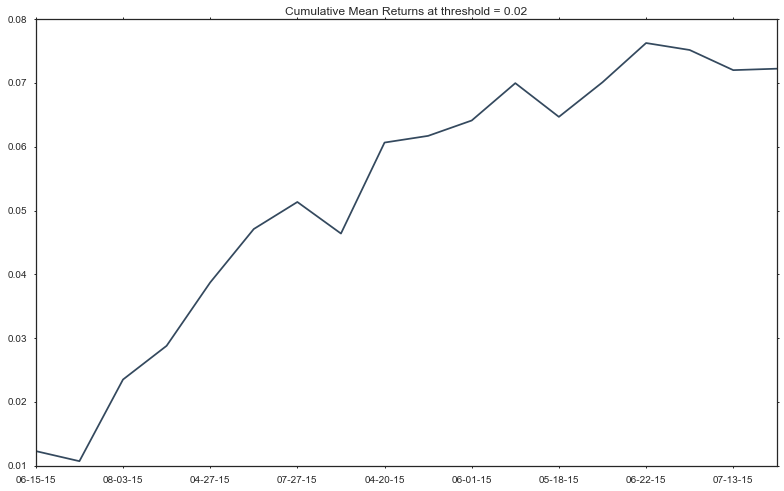

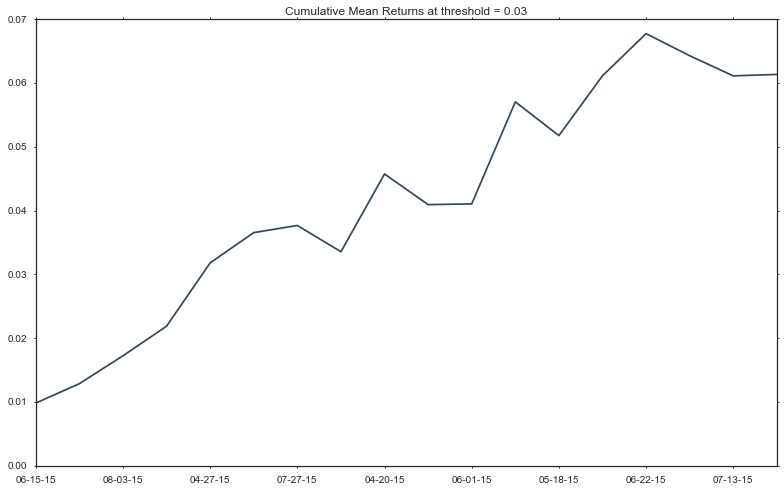

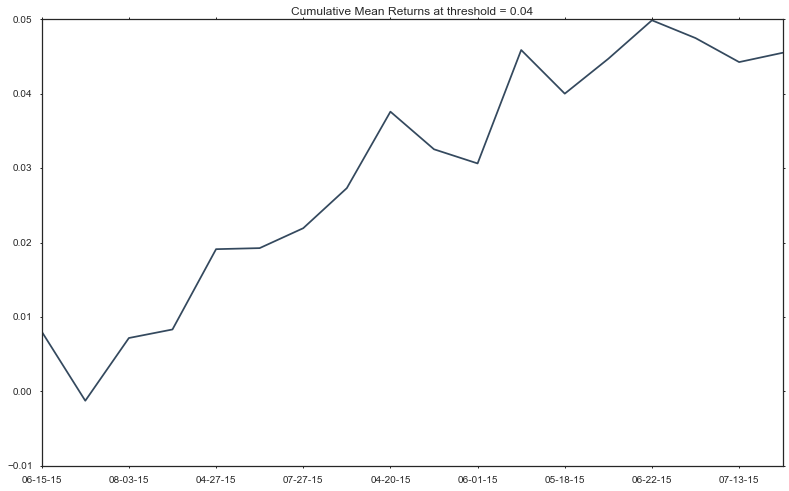

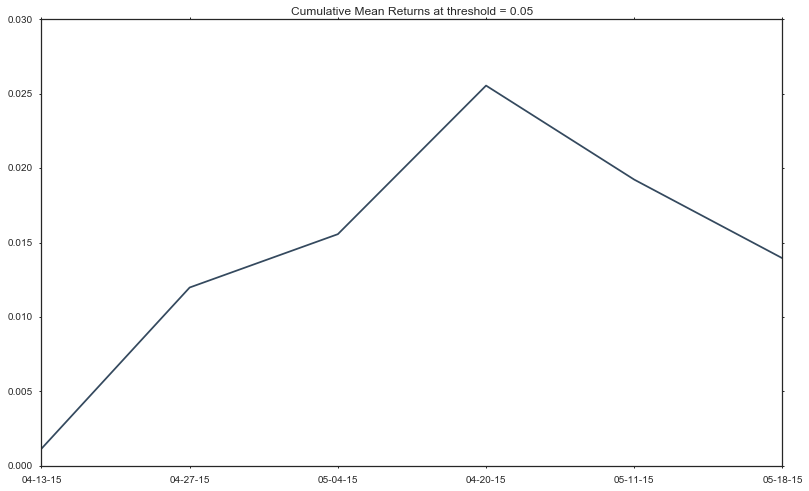

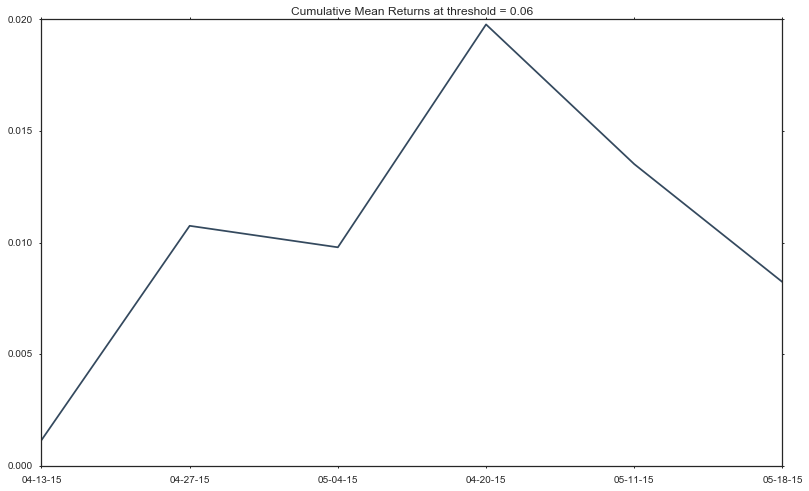

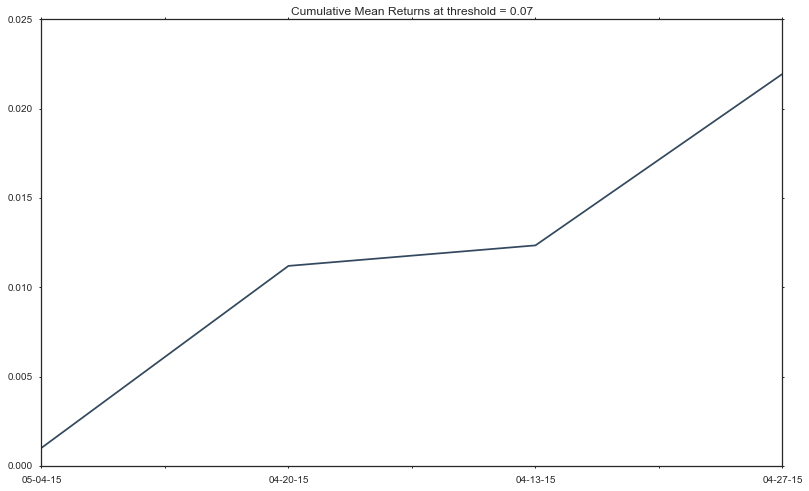

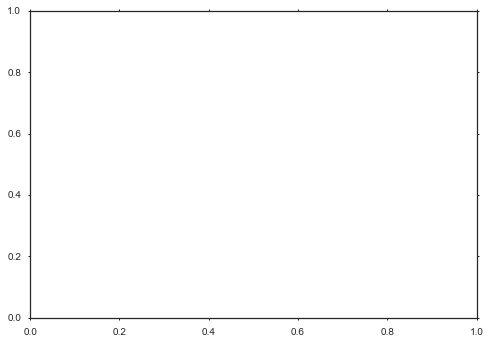

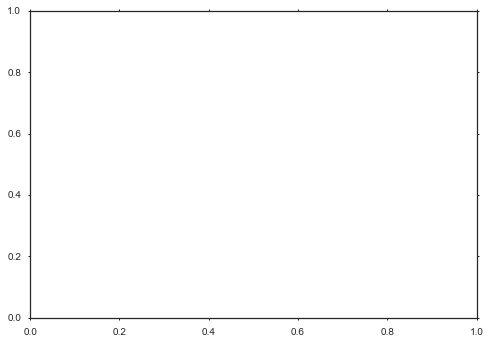

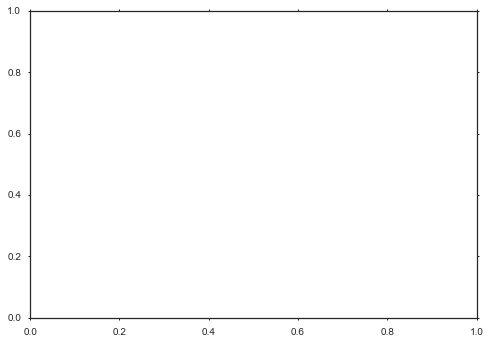

In [14]:
# plot cumulative returns from distro
for thresh in sorted(list(pbt_dict.keys())):
    try:
        fig, ax = plt.subplots()
        HPR[thresh].cumsum().plot(figsize=size, ax=ax, color=flatui[4])
        plt.title('Cumulative Mean Returns at threshold = {}'.format(thresh))
        #plt.axhline(0, lw=1, color='k')
    except: pass

In [20]:
# NEGATIVE THRESHOLDS
mondays = [date[MON] for date in dates]
fridays = [date[FRI] for date in dates]
#len(list(pos_bin_dict.items())) # <= index due based on positive or negative thresholds exceeded
# ======================================================================= #
pos_thresh = [0., .01, .02, .03, .04, .05, .06, .07, .1, .15, .2]
neg_thresh = [ flt * -1. for flt in pos_thresh ]

nbt_dict = {} # agg pos_bin_dict by return thresholds
# calculate quintiles
for thresh in neg_thresh:
    try:
        neg_bin_dict = {}
        for k, v in by_date_neg.items():
            tmp = pd.DataFrame()
            #print(thresh)
            tmp['Percent_Total'] = v.loc[thresh].astype(float)
            tmp['Quintiles'] = pd.qcut(tmp['Percent_Total'], 2, labels=False)
            neg_bin_dict[k] = tmp.sort_values('Percent_Total', ascending=False)
            #print(tmp.sort_values('Percent_Total', ascending=False))
    except: pass
    nbt_dict[thresh] = neg_bin_dict 
# ======================================================================= #

HPR_n = {} # hpr by thresh
for thresh in nbt_dict.keys():
    hpr_long = pd.Series() # long portfolio holding period rets
    hpr_short = pd.Series()
    LS = pd.Series()
    for k, v in nbt_dict[thresh].items(): 
        tgt_date = pd.to_datetime(k)
        # select quintile and get symbols
        top_q_syms = list(v[v['Quintiles']==1].index)
        bottom_q_syms = list(v[v['Quintiles']==0].index)
        try:
            for i, n in enumerate(dates):
                if n[MON] == tgt_date: # get location of date
                    next_monday_close = dates[i + 1][MON]
        except: continue
            
        hpr_long.loc[tgt_date.date().strftime('%m-%d-%y')] = by_date_returns[next_monday_close][top_q_syms].mean()
        hpr_short.loc[tgt_date.date().strftime('%m-%d-%y')] = by_date_returns[next_monday_close][bottom_q_syms].mean()
        
        long = hpr_long.loc[tgt_date.date().strftime('%m-%d-%y')]
        short = hpr_short.loc[tgt_date.date().strftime('%m-%d-%y')]
        
        LS.loc[tgt_date.date().strftime('%m-%d-%y')] = long - short
    HPR_n[thresh] = LS

# ======================================================================= #
for thresh in sorted(list(nbt_dict.keys()), reverse=True):
    try:
        print('negative threshold: {:3.2%} | mean return: {:3.2%} | sum: {:3.2%}'.format(thresh,
                                                                          Decimal(HPR_n[thresh].mean()).quantize(dplaces),
                                                                          Decimal(HPR_n[thresh].sum()).quantize(dplaces)
                                                                                        ))
    except: pass

negative threshold: -0.00% | mean return: 0.18% | sum: 8.76%
negative threshold: -1.00% | mean return: 0.17% | sum: 8.43%
negative threshold: -2.00% | mean return: 0.21% | sum: 7.63%
negative threshold: -3.00% | mean return: 0.16% | sum: 5.59%
negative threshold: -4.00% | mean return: 0.05% | sum: 1.62%
negative threshold: -5.00% | mean return: 0.10% | sum: 2.14%
negative threshold: -6.00% | mean return: NaN% | sum: 0.00%
negative threshold: -7.00% | mean return: NaN% | sum: 0.00%
negative threshold: -10.00% | mean return: NaN% | sum: 0.00%
negative threshold: -15.00% | mean return: NaN% | sum: 0.00%
negative threshold: -20.00% | mean return: NaN% | sum: 0.00%


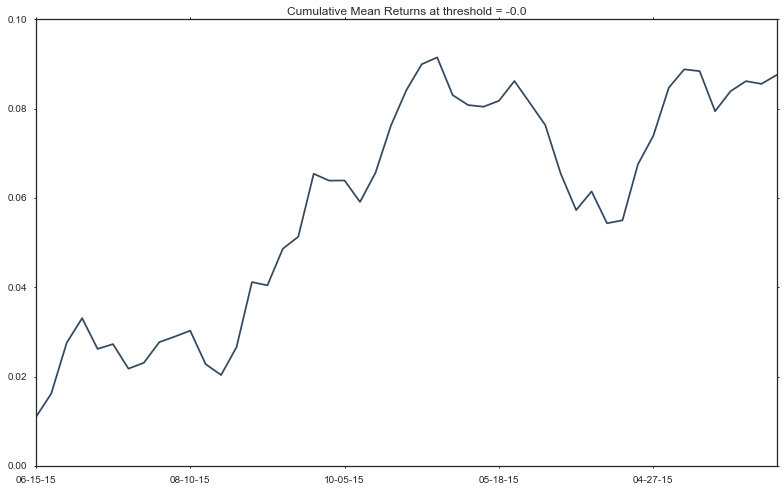

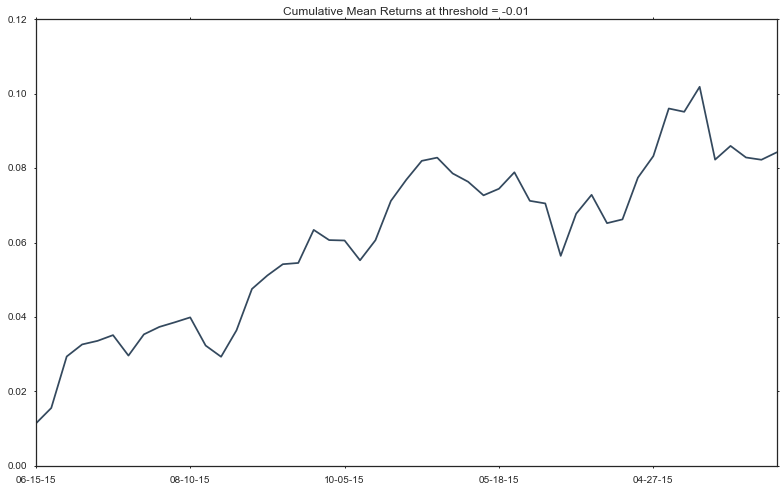

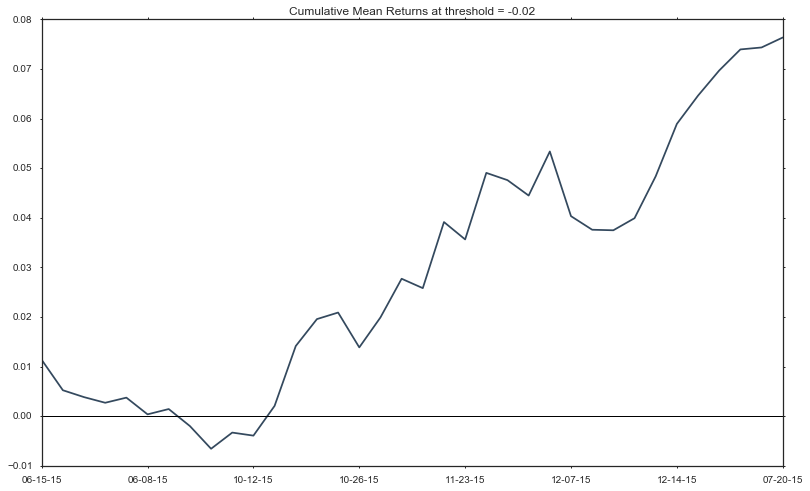

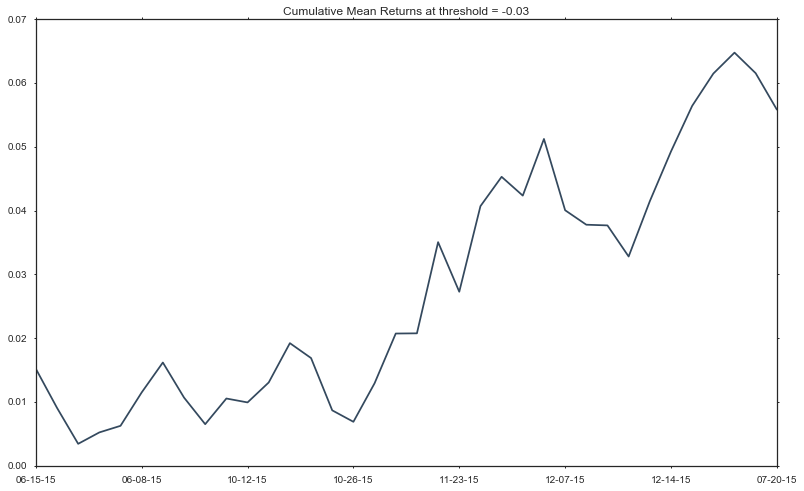

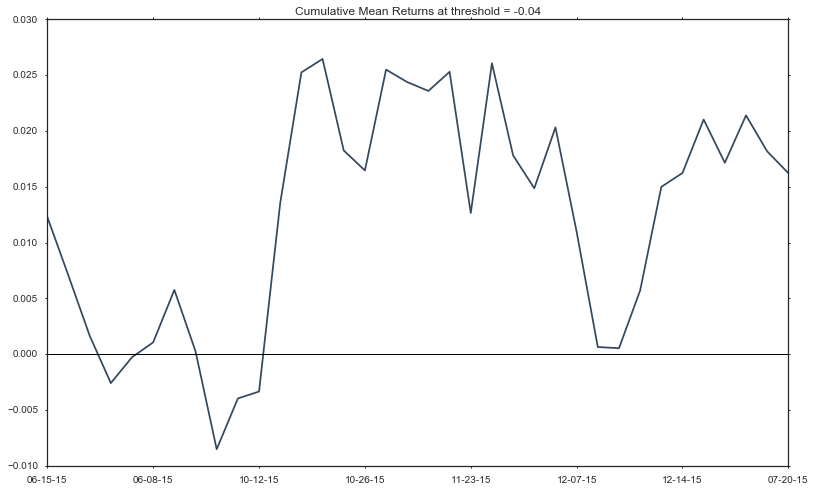

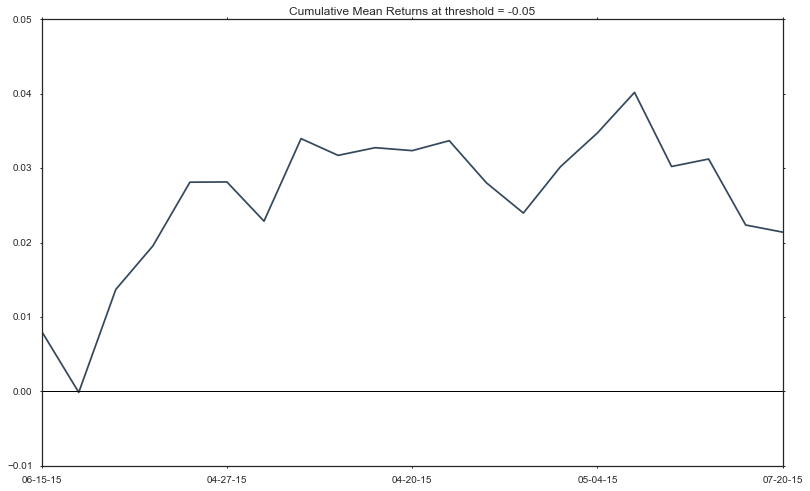

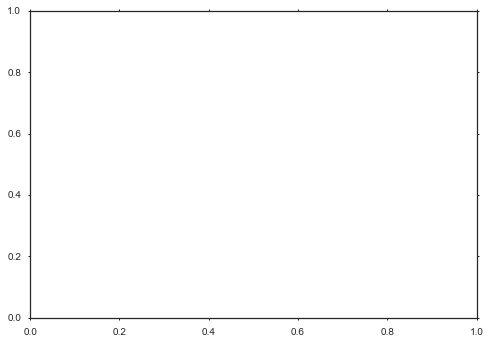

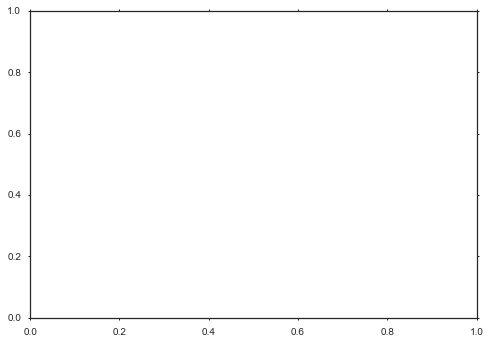

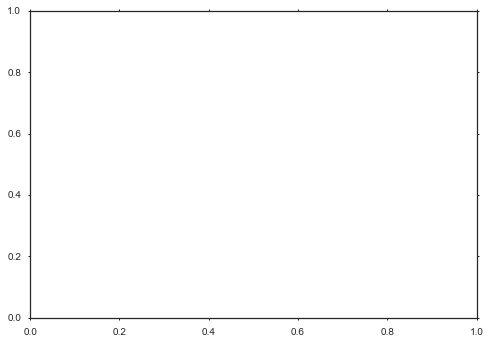

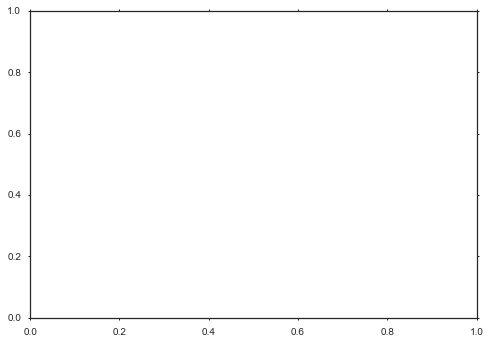

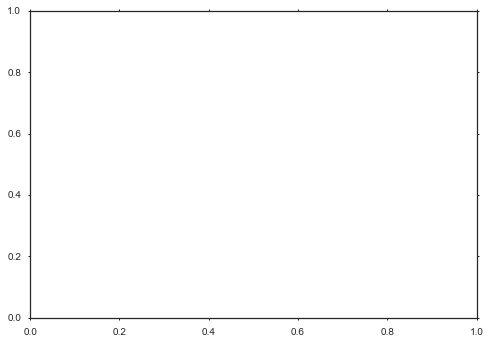

In [18]:
# plot cumulative returns from distro
for thresh in sorted(list(nbt_dict.keys()), reverse=True):
    try:
        fig, ax = plt.subplots()
        HPR_n[thresh].cumsum().plot(figsize=size, ax=ax, color=flatui[4])
        plt.title('Cumulative Mean Returns at threshold = {}'.format(thresh))
        plt.axhline(0, lw=1, color='k')
    except: pass

In [ ]:
# create portfolios based on pct pos, pct neg
import sympy
